In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import time
from visual_odometry import VisualOdometry
import math
from skimage import filters

# Load images
image_dir = 'data/images'
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

In [ ]:
# Display images one by one
for image in images:
    plt.figure(figsize=(20, 5))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    try:
        time.sleep(0.1)  # Adjust the delay as needed
    except KeyboardInterrupt:
        clear_output(wait=True)
        break

##### Here we are going to be working with a subset of kitti sequence 00, specifically the first 1000 frame of this sequence
# First, canny algorithm on kitti sequence-

### So first is the canny algorithm I wrote as part of assignment one, slighly revised to work in a single function call for this task

In [3]:
''' This is all code from assignment 1, just rewritten to be in a single function call. '''
def canny_edge_detection(image, l=5, sig=2, low_threshold=1, high_threshold=10):
    def create_gauss(l=5, sig=1):
        r = range(-int(l/2), int(l/2)+1)
        gauss = [1 / (sig * math.sqrt(2 * math.pi)) * math.exp(-float(x)**2/(2*sig**2)) for x in r]
        gauss = np.array(gauss).reshape(1, l)
        return gauss

    def convolve(img, kernel):
        image0, image1, kernel0, kernel1 = *img.shape, *kernel.shape
        out_image0, out_image1 = image0 - kernel0 + 1, image1 - kernel1 + 1
        ix0 = np.arange(kernel0)[:, None] + np.arange(out_image0)[None, :]
        ix1 = np.arange(kernel1)[:, None] + np.arange(out_image1)[None, :]
        out_image = kernel[:, None, :, None] * img[(ix0.ravel()[:, None], ix1.ravel()[None, :])].reshape(kernel0, out_image0, kernel1, out_image1)
        out_image = out_image.transpose(1, 3, 0, 2).reshape(out_image0, out_image1, -1).sum(axis=-1)
        return out_image

    def non_max_suppression(img, D):
        M, N = img.shape
        Z = np.zeros((M, N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180

        for i in range(1, M-1):
            for j in range(1, N-1):
                try:
                    q = 255
                    r = 255
                    if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    elif (22.5 <= angle[i, j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    elif (67.5 <= angle[i, j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    elif (112.5 <= angle[i, j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i, j] >= q) and (img[i, j] >= r):
                        Z[i, j] = img[i, j]
                    else:
                        Z[i, j] = 0

                except IndexError as e:
                    pass

        return Z

    gauss = create_gauss(l, sig)
    x_blur = convolve(image, gauss)
    y_blur = convolve(image, gauss.T)
    full_blur = convolve(x_blur, gauss.T)

    Gx = np.array([[1, 0, -1]])
    Gy = Gx.T

    Ix = convolve(full_blur, Gx)
    Iy = convolve(full_blur, Gy)

    Ix_resize = cv2.resize(Ix, (image.shape[1], image.shape[0]))
    Iy_resize = cv2.resize(Iy, (image.shape[1], image.shape[0]))

    grad_magnitude = np.sqrt((Ix_resize**2) + (Iy_resize**2))
    grad_magnitude_resize = cv2.resize(grad_magnitude, (image.shape[1], image.shape[0]))

    grad_dir = np.zeros((Iy_resize.shape[0], Iy_resize.shape[1]), dtype=float)
    for i in range(Iy_resize.shape[0]):
        for j in range(Iy_resize.shape[1]):
            grad_dir[i][j] = math.atan2(Iy_resize[i][j], Ix_resize[i][j])

    nm_img = non_max_suppression(grad_magnitude_resize, grad_dir)
    hyster_image = filters.apply_hysteresis_threshold(nm_img, low_threshold, high_threshold)

    return hyster_image

## Now we run that algorithm over the clipped dataset

In [ ]:
# Display images one by one with Canny edge detection
for image in images:
    edges = canny_edge_detection(image)  # Adjust the thresholds as needed | l, sig, low_threshold, high_threshold
    plt.figure(figsize=(20, 5))
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.5)  # Adjust the delay as needed

# And just for comparison purposes we will now do the same thing, just using opencv's built in canny edge detector

In [ ]:
# Display images one by one with Canny edge detection
for image in images:
    edges = cv2.Canny(image, 100, 200)  # Adjust the thresholds as needed
    plt.figure(figsize=(20, 5))
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.5)  # Adjust the delay as needed

### This is cool, now we can run a pre-processing algorithm over a video (specifically in this case 1000 consecutive frames) to get some sort of effect. How can we now extend this idea to make it useful for a specific task/goal?

#### What we can do is create a visual odometry algorithm that will take in our input images to track position of the camera over time vs ground truth.

# Next, a quick exploration of Mono Visual Odometry on Kitti

Before getting into the full visual odometry pipeline, it would be good to show what is happening to an extent here. In the next cell block we are visualizing the keypoint detection process that is used in the visual odometry pipeline. What we are doing is finding 'features' in the images, which are essentially noteable pixel clusters, that we are then able to track over n number of frames. This tracking is used to recover the camera position in the world frame and determine how much the camera has moved between frames.

By default, orb is tracking up to 500 keypoints which is what we will use for below for visualization purposes.

In [ ]:
# ORB feature detector
orb = cv2.ORB_create()
for image in images: # For all images in the clipped dataset
    keypoints, descriptors = orb.detectAndCompute(image, None) # Detect keypoints and compute descriptors
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT) # Draw keypoints for visualization purposes
    
    # Display the images with matplotlib
    plt.figure(figsize=(20, 5))
    plt.imshow(image_with_keypoints)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.1)  # Adjust the delay

From here, we are going to load in our VO pipeline which follows this process and computes the position of the camera in each frame. It tracks that position overtime and will plot the estimated trajectory by the visual odometry algorithm, compared to the ground truth position values provided in the kitti dataset.

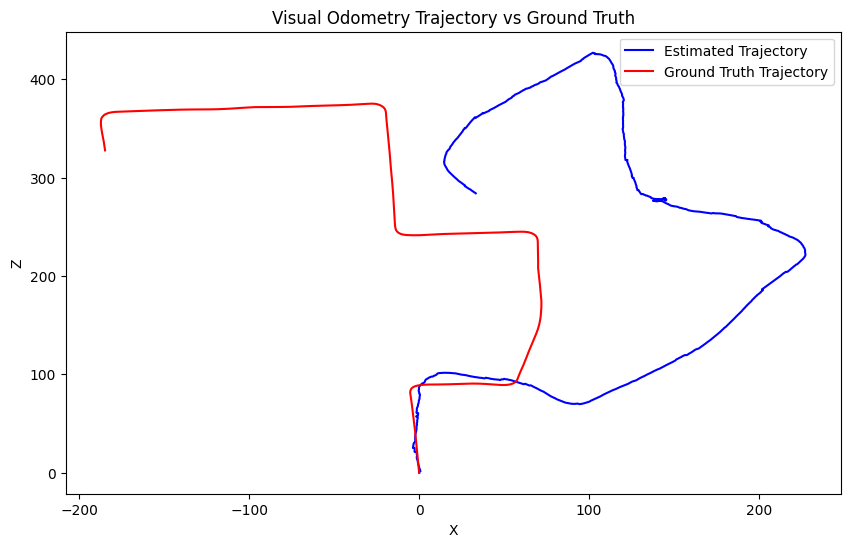

In [ ]:
# Initialize the VisualOdometry class with the data directory
data_dir = 'data'
vo = VisualOdometry(data_dir)

# Process each frame and display the current pose
estimated_poses = []
for frame_id in range(len(vo.images)):
    vo.process_frame(frame_id)
    cur_pose = vo.get_current_pose()
    estimated_poses.append(cur_pose[:3, 3])  # Append the translation part of the pose

# Convert estimated poses to a numpy array for easier plotting
estimated_poses = np.array(estimated_poses)

# Extract ground truth poses for the first 1001 images | without this it displays the full path.
ground_truth_poses = np.array([pose[:3, 3] for pose in vo.poses[:1001]])

# Plot the estimated trajectory and ground truth trajectory
plt.figure(figsize=(10, 6))
plt.plot(estimated_poses[:, 0], estimated_poses[:, 2], label='Estimated Trajectory', color='blue')
plt.plot(ground_truth_poses[:, 0], ground_truth_poses[:, 2], label='Ground Truth Trajectory', color='red')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Visual Odometry Trajectory vs Ground Truth')
plt.legend()
plt.show()

Ok so now that we have done an initial visual odometry run we can see the ground truth accuracy in red vs the predicted accuracy of the VO algorithm in blue. We can see that, at least initially, the predicted is following the ground truth but then quickly deviates and remains off for the rest of the run. We can see that the shape of the estimated trajectory matches the ground truth, to a certain degree, but because of drifting and noise in images we are deviated far from ground truth.

## Next lets look at the first pre-processing method to see if we have any improvements.

# First looking at adding in ClaHe and Gaussian Blurring

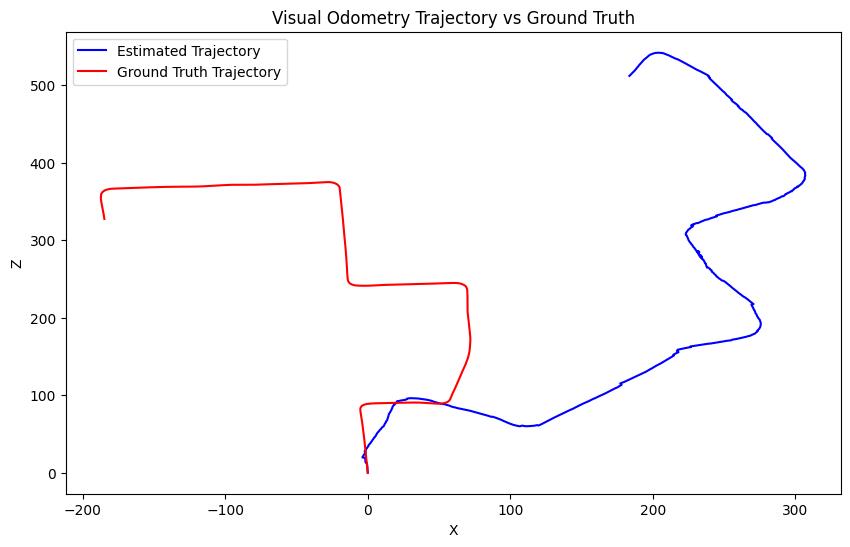

In [14]:
class VisualOdometryWithPreprocessing(VisualOdometry):
    def __init__(self, data_dir, preprocess_fn):
        super().__init__(data_dir)
        self.preprocess_fn = preprocess_fn

    def process_frame(self, frame_id):
        img = self.images[frame_id] # Get the image ID corresponding to the current frame
        
        # Apply preprocessing
        img = self.preprocess_fn(img)
        
        kp, des = self.orb.detectAndCompute(img, None) # Use ORB to detect the keypoints and compute descriptor vectors
        
        if self.prev_kp is not None: # If we have keypoints, proceed
            matches = self.bf.match(self.prev_des, des) # Match descriptors between frames
            matches = sorted(matches, key=lambda x: x.distance) # Sort the matches by distance
            src_pts = np.float32([self.prev_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the source points
            dst_pts = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the destination points
            E, mask = cv2.findEssentialMat(dst_pts, src_pts, self.K, method=cv2.RANSAC, prob=0.999, threshold=1.0) # Compute the essential matrix using RANSAC to handle any keypoint outliers
            _, R, t, mask = cv2.recoverPose(E, dst_pts, src_pts, self.K) # Recover the pose (translation and rotation) from the computed essential matrix
            
            Rt = np.eye(4) # Convert the computed rotation and translation into the 4x4 transformation matrix representing the camera position in the world frame
            Rt[:3, :3] = R
            Rt[:3, 3] = t.squeeze()
            
            # Update the pose with the computed transformation matrix
            self.cur_pose = self.cur_pose @ Rt
        
        # Upate the previous keypoints and descriptors with the current computed ones
        self.prev_kp = kp
        self.prev_des = des

# Define the preprocessing function
def preprocess_image(image):
    # Apply CLAHE for contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
    return blurred_image

# Initialize the VisualOdometryWithPreprocessing class with the data directory and preprocessing function
data_dir = 'data'
vo = VisualOdometryWithPreprocessing(data_dir, preprocess_fn=preprocess_image)

# Process each frame and display the current pose
estimated_poses = []
for frame_id in range(len(vo.images)):
    vo.process_frame(frame_id)
    cur_pose = vo.get_current_pose()
    estimated_poses.append(cur_pose[:3, 3])  # Append the translation part of the pose

# Convert estimated poses to a numpy array for easier plotting
estimated_poses = np.array(estimated_poses)

# Extract ground truth poses for the first 1001 images
ground_truth_poses = np.array([pose[:3, 3] for pose in vo.poses[:1001]])

# Plot the estimated trajectory and ground truth trajectory
plt.figure(figsize=(10, 6))
plt.plot(estimated_poses[:, 0], estimated_poses[:, 2], label='Estimated Trajectory', color='blue')
plt.plot(ground_truth_poses[:, 0], ground_truth_poses[:, 2], label='Ground Truth Trajectory', color='red')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Visual Odometry Trajectory vs Ground Truth')
plt.legend()
plt.show()

So this is the new comparison between ground truth and the new VO algorithm that does ClaHe and gaussian processing. The results are still not perfect (which will be discussed much more in the paper) but what we can see is that the actual estimated trajectory follows a path that resembles the ground truth much closer than base, even though it is till far from the ground truth position. What this is showing us is that the additional pre-processing steps have assisted the algorithm in tracking between frames so that it stays on path more than without any processing.

# Now lets examine additional methods to see how much this could be improved.

# Next, lets look at the addition of normalization to our algorithm to bring the total amount of pre-processing steps to 3.

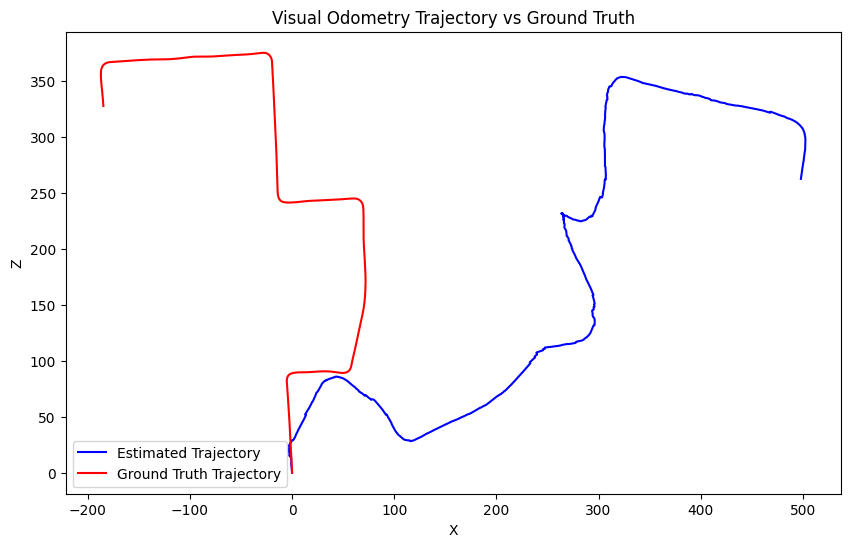

In [18]:
class VisualOdometryWithPreprocessing(VisualOdometry):
    def __init__(self, data_dir, preprocess_fn):
        super().__init__(data_dir)
        self.preprocess_fn = preprocess_fn

    def process_frame(self, frame_id):
        img = self.images[frame_id] # Get the image ID corresponding to the current frame
        
        # Apply preprocessing
        img = self.preprocess_fn(img)
        
        kp, des = self.orb.detectAndCompute(img, None) # Use ORB to detect the keypoints and compute descriptor vectors
        
        if self.prev_kp is not None: # If we have keypoints, proceed
            matches = self.bf.match(self.prev_des, des) # Match descriptors between frames
            matches = sorted(matches, key=lambda x: x.distance) # Sort the matches by distance
            src_pts = np.float32([self.prev_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the source points
            dst_pts = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the destination points
            E, mask = cv2.findEssentialMat(dst_pts, src_pts, self.K, method=cv2.RANSAC, prob=0.999, threshold=1.0) # Compute the essential matrix using RANSAC to handle any keypoint outliers
            _, R, t, mask = cv2.recoverPose(E, dst_pts, src_pts, self.K) # Recover the pose (translation and rotation) from the computed essential matrix
            
            Rt = np.eye(4) # Convert the computed rotation and translation into the 4x4 transformation matrix representing the camera position in the world frame
            Rt[:3, :3] = R
            Rt[:3, 3] = t.squeeze()
            
            # Update the pose with the computed transformation matrix
            self.cur_pose = self.cur_pose @ Rt
        
        # Upate the previous keypoints and descriptors with the current computed ones
        self.prev_kp = kp
        self.prev_des = des

# Define the preprocessing function
def preprocess_image(image):
    # Apply CLAHE for contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(clahe_image, (3, 3), 0)
    
    # Normalize the image to the range [0, 255]
    normalized_image = cv2.normalize(blurred_image, None, 0, 255, cv2.NORM_MINMAX)
    
    return normalized_image

# Initialize the VisualOdometryWithPreprocessing class with the data directory and preprocessing function
data_dir = 'data'
vo = VisualOdometryWithPreprocessing(data_dir, preprocess_fn=preprocess_image)

# Process each frame and display the current pose
estimated_poses = []
for frame_id in range(len(vo.images)):
    vo.process_frame(frame_id)
    cur_pose = vo.get_current_pose()
    estimated_poses.append(cur_pose[:3, 3])  # Append the translation part of the pose

# Convert estimated poses to a numpy array for easier plotting
estimated_poses = np.array(estimated_poses)

# Extract ground truth poses for the first 1001 images
ground_truth_poses = np.array([pose[:3, 3] for pose in vo.poses[:1001]])

# Plot the estimated trajectory and ground truth trajectory
plt.figure(figsize=(10, 6))
plt.plot(estimated_poses[:, 0], estimated_poses[:, 2], label='Estimated Trajectory', color='blue')
plt.plot(ground_truth_poses[:, 0], ground_truth_poses[:, 2], label='Ground Truth Trajectory', color='red')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Visual Odometry Trajectory vs Ground Truth')
plt.legend()
plt.show()

Interesting. By adding in our normalization step and reducing the gaussian kernal size down to 3x3 we are seeing that we are still far from our ground truth position and that we seem to have overly rotated during a turn about 3/4 of the way through the video. However, what we do observe here is that the scale of the estimated trajectory is getting a lot closer to the ground truth values. We are still overshooting, but not nearly as much as we were previously.

# Next lets take a look at the effect of denoising

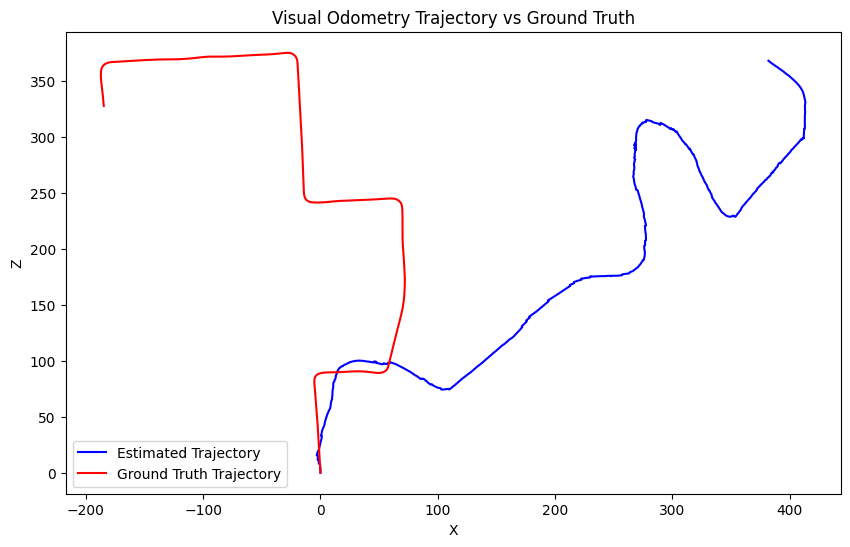

In [20]:
class VisualOdometryWithPreprocessing(VisualOdometry):
    def __init__(self, data_dir, preprocess_fn):
        super().__init__(data_dir)
        self.preprocess_fn = preprocess_fn

    def process_frame(self, frame_id):
        img = self.images[frame_id] # Get the image ID corresponding to the current frame
        
        # Apply preprocessing
        img = self.preprocess_fn(img)
        
        kp, des = self.orb.detectAndCompute(img, None) # Use ORB to detect the keypoints and compute descriptor vectors
        
        if self.prev_kp is not None: # If we have keypoints, proceed
            matches = self.bf.match(self.prev_des, des) # Match descriptors between frames
            matches = sorted(matches, key=lambda x: x.distance) # Sort the matches by distance
            src_pts = np.float32([self.prev_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the source points
            dst_pts = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the destination points
            E, mask = cv2.findEssentialMat(dst_pts, src_pts, self.K, method=cv2.RANSAC, prob=0.999, threshold=1.0) # Compute the essential matrix using RANSAC to handle any keypoint outliers
            _, R, t, mask = cv2.recoverPose(E, dst_pts, src_pts, self.K) # Recover the pose (translation and rotation) from the computed essential matrix
            
            Rt = np.eye(4) # Convert the computed rotation and translation into the 4x4 transformation matrix representing the camera position in the world frame
            Rt[:3, :3] = R
            Rt[:3, 3] = t.squeeze()
            
            # Update the pose with the computed transformation matrix
            self.cur_pose = self.cur_pose @ Rt
        
        # Upate the previous keypoints and descriptors with the current computed ones
        self.prev_kp = kp
        self.prev_des = des

# Define the preprocessing function
def preprocess_image(image):
    # Apply CLAHE for contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
    # Apply denoising
    denoised_image = cv2.fastNlMeansDenoising(blurred_image, None, h=10, templateWindowSize=7, searchWindowSize=21)
    
    return denoised_image

# Initialize the VisualOdometryWithPreprocessing class with the data directory and preprocessing function
data_dir = 'data'
vo = VisualOdometryWithPreprocessing(data_dir, preprocess_fn=preprocess_image)

# Process each frame and display the current pose
estimated_poses = []
for frame_id in range(len(vo.images)):
    vo.process_frame(frame_id)
    cur_pose = vo.get_current_pose()
    estimated_poses.append(cur_pose[:3, 3])  # Append the translation part of the pose

# Convert estimated poses to a numpy array for easier plotting
estimated_poses = np.array(estimated_poses)

# Extract ground truth poses for the first 1001 images
ground_truth_poses = np.array([pose[:3, 3] for pose in vo.poses[:1001]])

# Plot the estimated trajectory and ground truth trajectory
plt.figure(figsize=(10, 6))
plt.plot(estimated_poses[:, 0], estimated_poses[:, 2], label='Estimated Trajectory', color='blue')
plt.plot(ground_truth_poses[:, 0], ground_truth_poses[:, 2], label='Ground Truth Trajectory', color='red')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Visual Odometry Trajectory vs Ground Truth')
plt.legend()
plt.show()

This attempt at additional denoising seems to cause more harm than good, proving that not all pre-processing methods will help here. Lets try a final method

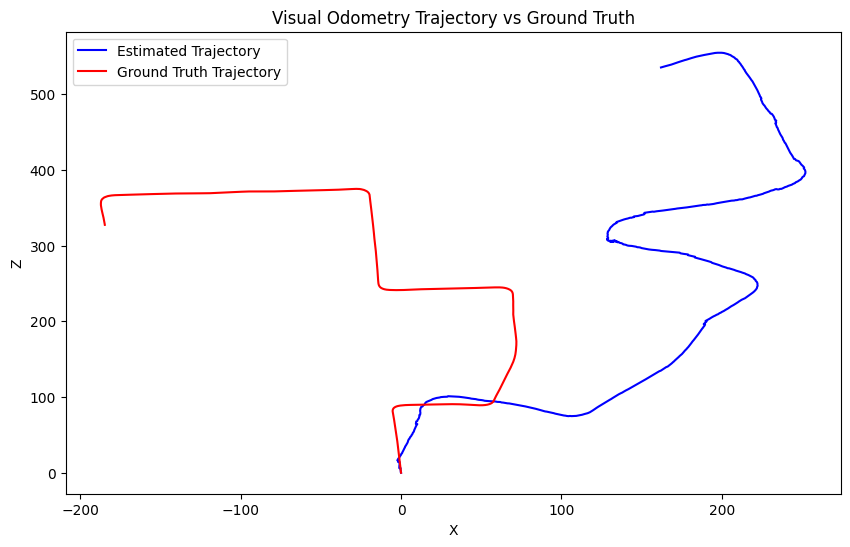

In [ ]:
class VisualOdometryWithPreprocessing(VisualOdometry):
    def __init__(self, data_dir, preprocess_fn):
        super().__init__(data_dir)
        self.preprocess_fn = preprocess_fn

    def process_frame(self, frame_id):
        img = self.images[frame_id] # Get the image ID corresponding to the current frame
        
        # Apply preprocessing
        img = self.preprocess_fn(img)
        
        kp, des = self.orb.detectAndCompute(img, None) # Use ORB to detect the keypoints and compute descriptor vectors
        
        if self.prev_kp is not None: # If we have keypoints, proceed
            matches = self.bf.match(self.prev_des, des) # Match descriptors between frames
            matches = sorted(matches, key=lambda x: x.distance) # Sort the matches by distance
            src_pts = np.float32([self.prev_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the source points
            dst_pts = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) # Get the destination points
            E, mask = cv2.findEssentialMat(dst_pts, src_pts, self.K, method=cv2.RANSAC, prob=0.999, threshold=1.0) # Compute the essential matrix using RANSAC to handle any keypoint outliers
            _, R, t, mask = cv2.recoverPose(E, dst_pts, src_pts, self.K) # Recover the pose (translation and rotation) from the computed essential matrix
            
            Rt = np.eye(4) # Convert the computed rotation and translation into the 4x4 transformation matrix representing the camera position in the world frame
            Rt[:3, :3] = R
            Rt[:3, 3] = t.squeeze()
            
            # Update the pose with the computed transformation matrix
            self.cur_pose = self.cur_pose @ Rt
        
        # Upate the previous keypoints and descriptors with the current computed ones
        self.prev_kp = kp
        self.prev_des = des

# Define the preprocessing function
def preprocess_image(image):
    # Apply CLAHE for contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(blurred_image)
    
    # Apply bilateral filtering to reduce noise while preserving edges
    bilateral_filtered_image = cv2.bilateralFilter(equalized_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Apply sharpening
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(bilateral_filtered_image, -1, kernel)
    
    return sharpened_image

# Initialize the VisualOdometryWithPreprocessing class with the data directory and preprocessing function
data_dir = 'data'
vo = VisualOdometryWithPreprocessing(data_dir, preprocess_fn=preprocess_image)

# Process each frame and display the current pose
estimated_poses = []
for frame_id in range(len(vo.images)):
    vo.process_frame(frame_id)
    cur_pose = vo.get_current_pose()
    estimated_poses.append(cur_pose[:3, 3])  # Append the translation part of the pose

# Convert estimated poses to a numpy array for easier plotting
estimated_poses = np.array(estimated_poses)

# Extract ground truth poses for the first 1001 images
ground_truth_poses = np.array([pose[:3, 3] for pose in vo.poses[:1001]])

# Plot the estimated trajectory and ground truth trajectory
plt.figure(figsize=(10, 6))
plt.plot(estimated_poses[:, 0], estimated_poses[:, 2], label='Estimated Trajectory', color='blue')
plt.plot(ground_truth_poses[:, 0], ground_truth_poses[:, 2], label='Ground Truth Trajectory', color='red')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Visual Odometry Trajectory vs Ground Truth')
plt.legend()
plt.show()